In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/Projects/QuantumFlow/notebooks")
except:
    pass

if tf.test.gpu_device_name() == '/device:GPU:0':
    print('Found GPU')

import sys
sys.path.append('../')

from quantumflow.generate_potentials import generate_potentials
from quantumflow.calculus_utils import integrate, integrate_simpson, laplace
from quantumflow.numerov_solver import NumerovSolver

import ipywidgets as widgets
from IPython.display import display

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found GPU


In [2]:
import pandas as pd

paper_coeff = pd.read_csv('../data/paper_potentials.txt', delimiter=' ')
paper_coeff.head()

,j,αj,a1,b1,c1,a2,b2,c2,a3,b3,c3
0,1,14.342672,1.180270,0.071951,0.529935,9.013205,0.092676,0.539643,7.210302,0.074083,0.412034
1,2,5.175361,6.168994,0.082993,0.516723,8.304951,0.089015,0.416912,8.804876,0.096599,0.571106
2,3,0.835534,9.080904,0.076853,0.562269,3.911675,0.075518,0.508665,1.809709,0.095977,0.402422
3,4,-5.373806,8.697231,0.063849,0.585946,8.673309,0.087693,0.485065,4.189229,0.045184,0.581924
4,5,-0.319073,1.880200,0.034255,0.487404,3.541515,0.098366,0.451515,9.826681,0.032646,0.435264


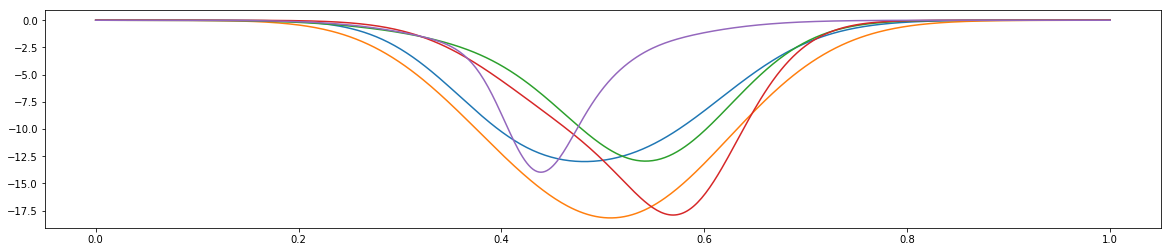

In [3]:
datadir = "../data"
dataset = "recreate_paper"

G = 500
length = 1
N = 4

a = paper_coeff[['a1', 'a2', 'a3']].values[:, np.newaxis, :]
c = paper_coeff[['b1', 'b2', 'b3']].values[:, np.newaxis, :] # b<->c listed wrong in the paper
b = paper_coeff[['c1', 'c2', 'c3']].values[:, np.newaxis, :]

np_x = np.linspace(0.0, length, G)
curves = -np.square(np_x[np.newaxis, :, np.newaxis] - b)/(2*np.square(c))
curves = -a*np.exp(curves)

np_potentials = np.sum(curves, -1)

h = (max(np_x) - min(np_x))/(G-1) # discretization width [bohr]

preview = 5

plt.figure(figsize=(20, 4))
plt.plot(np_x, np.transpose(np_potentials)[:, :preview]) # only plot first potentials
plt.show()

In [4]:
progress = widgets.IntProgress(value=0, max=0, description='init...', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

solver = NumerovSolver(G, h)

np_E, np_solutions = solver.solve_schroedinger(np_potentials, N, progress=progress)

if not os.path.exists(os.path.join(datadir, dataset)):
        os.makedirs(os.path.join(datadir, dataset))

with open(os.path.join(datadir, dataset, 'dataset_training.pkl'), 'wb') as f:
    pickle.dump([np_x, np_potentials, np_solutions, np_E], f)
    
print("dataset", dataset, "saved to", os.path.join(datadir, dataset))

IntProgress(value=0, bar_style='info', description='init...', layout=Layout(width='92%'), max=0)

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
dataset recreate_paper saved to ../data/recreate_paper


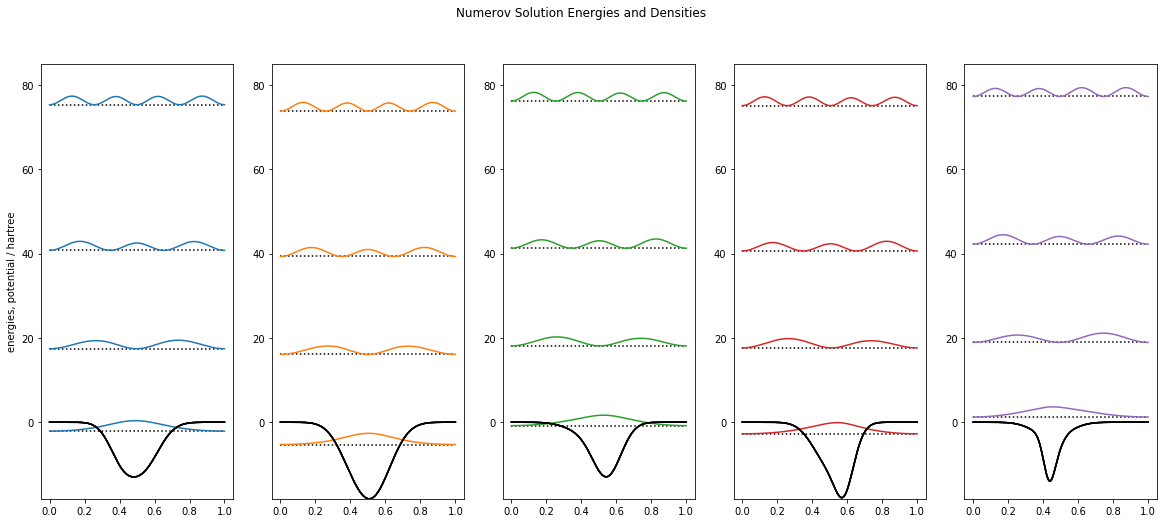

In [5]:
fig, axs = plt.subplots(1, preview, figsize=(20, 8))
for i, np_plot in enumerate(np_solutions[:preview]**2 + np_E[:preview, np.newaxis, :]):
    for n, np_plot_single in enumerate(np_plot.transpose()):
        axs[i].plot(np_x, np_potentials[i], 'k')
        axs[i].plot(np_x, np.ones(np_x.shape)*np_E[i, n], ':k')
        axs[i].plot(np_x, np_plot_single, 'C' + str(i%10))
        axs[i].set_ylim([np.min(np_potentials[:preview]), max(np.max(np_E[:preview]*1.1), 0.5)])
        if i == 0: axs[i].set_ylabel('energies, potential / hartree')
fig.suptitle('Numerov Solution Energies and Densities')
plt.show()

### recreate sample potential

dataset dataset_sample.pkl saved to ../data/recreate_paper


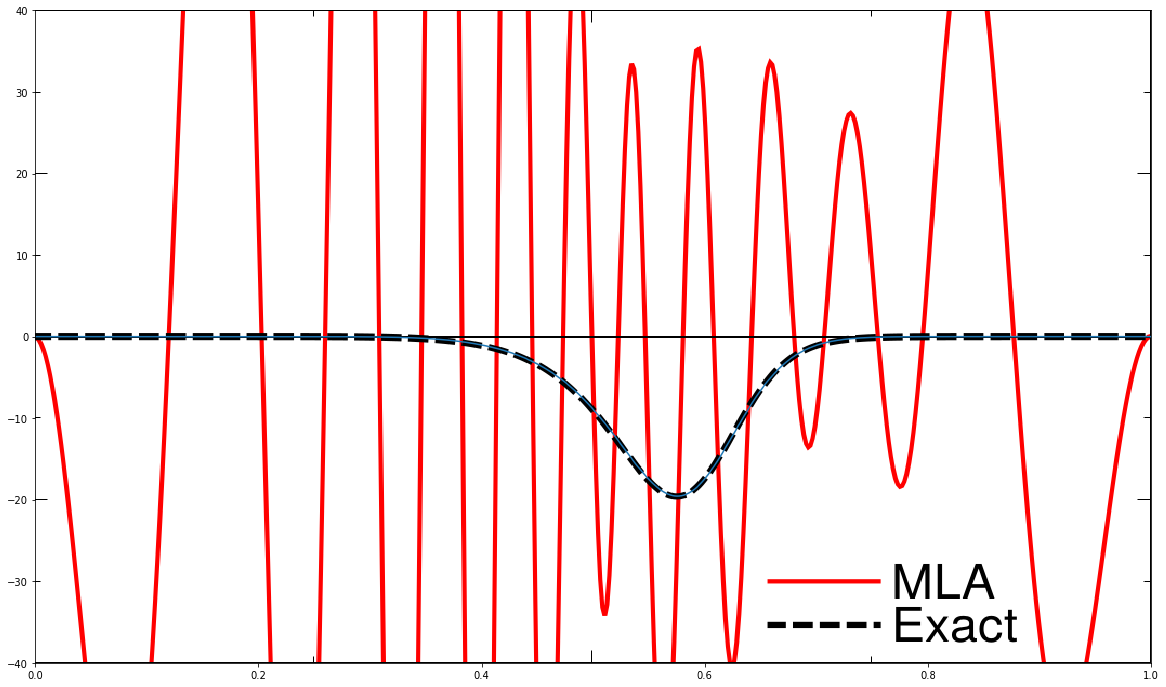

In [0]:
# parameters are found by gradient descent further down in the code
a = [4.02480191, 5.99455501, 10.76801402]
b = [0.52157438, 0.58645736, 0.57318963]
c = [0.07131018, 0.03986175, 0.05540802]

a = np.array(a)[np.newaxis, np.newaxis, :]
b = np.array(b)[np.newaxis, np.newaxis, :]
c = np.array(c)[np.newaxis, np.newaxis, :]

curves = -np.square(np_x[np.newaxis, :, np.newaxis] - b)/(2*np.square(c))
curves = -a*np.exp(curves)

np_sample = np.sum(curves, -1)

solver = NumerovSolver(G, h)

np_E_sample, np_solutions_sample = solver.solve_schroedinger(np_sample, N)

if not os.path.exists(os.path.join(datadir, dataset)):
        os.makedirs(os.path.join(datadir, dataset))

with open(os.path.join(datadir, dataset, 'dataset_sample.pkl'), 'wb') as f:
    pickle.dump([np_x, np_sample, np_solutions_sample, np_E_sample], f)
    
print("dataset dataset_sample.pkl saved to", os.path.join(datadir, dataset))

img = plt.imread("../data/sample_potential.png")
fig, ax = plt.subplots(figsize=(20, 12))
ax.imshow(img, extent=[0, 1, -40, 40])
plt.axis('auto')
plt.plot(np_x, np.transpose(np_sample))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


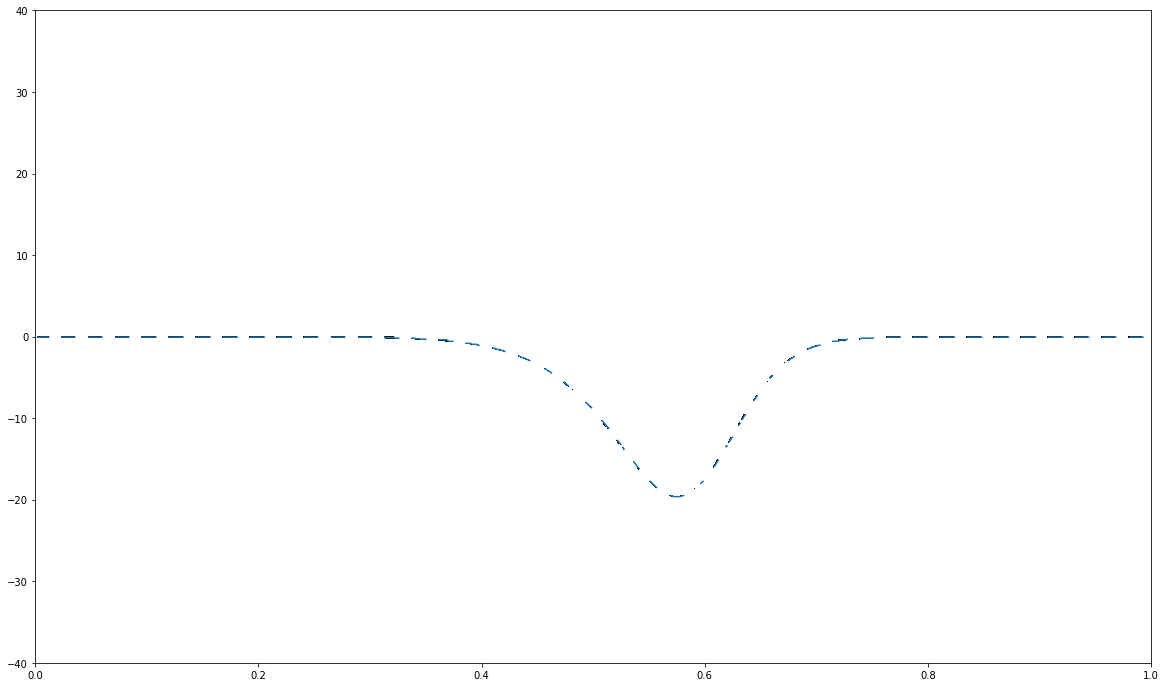

In [0]:
filtered_img = (img[:, :, 0] == 0)*1.0

kernel_size = 5
kernel = np.ones((kernel_size, kernel_size))/(kernel_size**2)
from scipy import ndimage
filtered_img = ndimage.convolve(filtered_img, kernel, mode='constant', cval=0.0)
filtered_img = (filtered_img > 0.92)*1.0
filtered_img[500:, 500:] = 0 # remove legend

y_mass = np.sum(filtered_img, axis=0)
y_data = np.sum(filtered_img*np.arange(filtered_img.shape[0])[:, np.newaxis], axis=0)/y_mass
y_data = -80*(y_data + 1/2 - filtered_img.shape[0]/2)/filtered_img.shape[0]
x_data = np.linspace(0, 1, filtered_img.shape[1])+0.5/filtered_img.shape[1]

filtered_img = 1 - filtered_img[:, :, np.newaxis]*np.ones((1, 1, 3))

fig, ax = plt.subplots(figsize=(20, 12))

ax.imshow(filtered_img, extent=[0, 1, -40, 40])
plt.axis('auto')
plt.plot(x_data, y_data)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


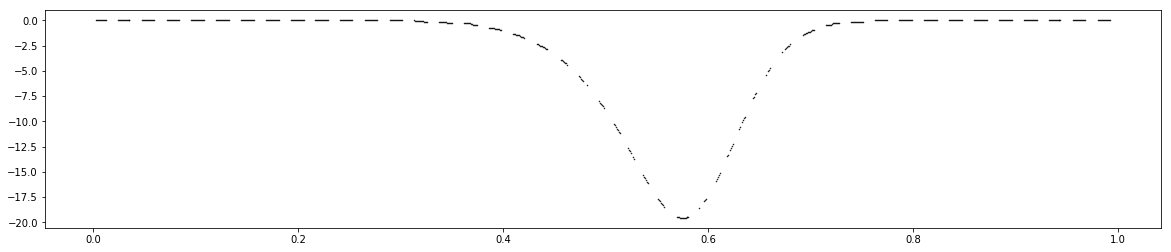

In [0]:
y_data -= np.nanmean(y_data[:100])
assert ~np.any(y_data > 0)

x_data = x_data[~np.isnan(y_data)]
y_data = y_data[~np.isnan(y_data)]

plt.figure(figsize=(20, 4))
plt.plot(x_data, y_data, '.k', markersize=1)
plt.show()

### solve the nonlinear optimization problem with tensorflow and gradient descent

In [0]:
n_optimize = 10
seed = 0

a_minmax=(1.0, 10.0) # [hartree] 
b_minmax=(0.4, 0.6) # nomalized x
c_minmax=(0.03, 0.1) # normalized x

tf.reset_default_graph()
tf.random.set_random_seed(seed)

a = tf.Variable(tf.random.uniform((n_optimize, 3), minval=a_minmax[0], maxval=a_minmax[1], dtype=tf.float64), name="a")
b = tf.Variable(tf.random.uniform((n_optimize, 3), minval=b_minmax[0], maxval=b_minmax[1], dtype=tf.float64), name="b")
logc = tf.Variable(tf.random.uniform((n_optimize, 3), minval=np.log(c_minmax[0]), maxval=np.log(c_minmax[1]), dtype=tf.float64), name="c") # avoid negative values

fit_x = tf.constant(x_data)
fit_y = tf.constant(y_data)
fit_weights = tf.constant(x_data)*0 + 1

curves = -tf.square(tf.expand_dims(tf.expand_dims(fit_x, 1), 0) - tf.expand_dims(b, 1))/(2*tf.square(tf.expand_dims(tf.exp(logc), 1)))
curves = -tf.expand_dims(a, 1)*tf.exp(curves)

fit_potentials = tf.reduce_sum(curves, -1)

individual_loss = tf.reduce_mean(tf.square(fit_potentials - tf.expand_dims(fit_y, 0)), -1)
loss = tf.reduce_sum(individual_loss)

In [0]:
optimizer = tf.train.AdamOptimizer(0.0002)
train = optimizer.minimize(loss)


np_a_list = []
np_b_list = []
np_c_list = []
loss_list = []

max_iterations = 100000

progress = widgets.IntProgress(value=0, max=max_iterations, description='optimizing', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(max_iterations):
        np_a, np_b, np_logc = sess.run([a, b, logc])
        np_c = np.exp(np_logc)
        
        np_a_list.append(np_a)
        np_b_list.append(np_b)
        np_c_list.append(np_c)
        
        np_loss, _ = sess.run([individual_loss, train])
        
        loss_list.append(np_loss)
    
        if step % 1000 == 0:
            progress.value = step
        
    np_a, np_b, np_logc = sess.run([a, b, logc])
    np_c = np.exp(np_logc)
    
    np_a_list.append(np_a)
    np_b_list.append(np_b)
    np_c_list.append(np_c)

IntProgress(value=0, bar_style='info', description='optimizing', layout=Layout(width='92%'), max=100000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


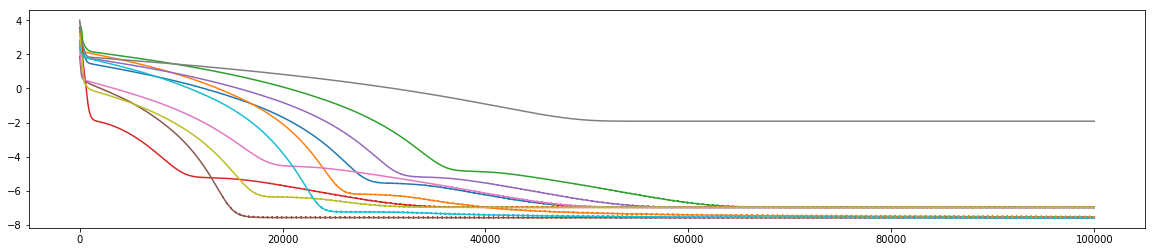

In [0]:
plt.figure(figsize=(20, 4))
plt.plot(np.log(loss_list))
plt.show()

In [0]:
np_a = np.array(np_a_list)
np_b = np.array(np_b_list)
np_c = np.array(np_c_list)

np_x = np.linspace(0.0, length, G)
curves = -np.square(np_x[np.newaxis, :, np.newaxis] - np_b[-1, :, np.newaxis])/(2*np.square(np_c[-1, :, np.newaxis]))
curves = -np_a[-1, :, np.newaxis]*np.exp(curves)

np_potentials = np.sum(curves, -1)

print(np_a[0, :, :])
print(np_b[0, :, :])
print(np_c[0, :, :])
print('')
print(np_a[-1, :, :])
print(np_b[-1, :, :])
print(np_c[-1, :, :])

[[5.32005123 5.40881873 6.09414957]
 [4.94274838 1.7012411  1.10455618]
 [2.31082444 5.35093935 9.60411969]
 [8.12483716 7.9069263  9.91514854]
 [5.46292853 3.86635713 6.13808074]
 [4.32797204 7.56196957 2.19300333]
 [1.09605295 9.12110322 4.81186994]
 [9.37883085 7.49439681 9.64646298]
 [8.86794924 6.38782575 6.03169223]
 [3.08734142 4.73898915 1.47469073]]
[[0.43053555 0.466392   0.48359949]
 [0.51173168 0.47992829 0.56560755]
 [0.43139601 0.42904986 0.40636917]
 [0.56822597 0.43123698 0.4238812 ]
 [0.52467881 0.49716527 0.4486651 ]
 [0.54623053 0.53183836 0.46595793]
 [0.44918939 0.51957001 0.49889   ]
 [0.44166291 0.4437453  0.45861003]
 [0.53472777 0.46519971 0.41210117]
 [0.44540157 0.54523094 0.58074926]]
[[0.09622662 0.06741774 0.03108296]
 [0.07918832 0.08188257 0.09795453]
 [0.09810967 0.07673166 0.08486587]
 [0.05463468 0.07033458 0.09254319]
 [0.04987116 0.07105095 0.04744028]
 [0.07577659 0.09826892 0.05696386]
 [0.036027   0.09121245 0.07926231]
 [0.07660867 0.03310465 0.

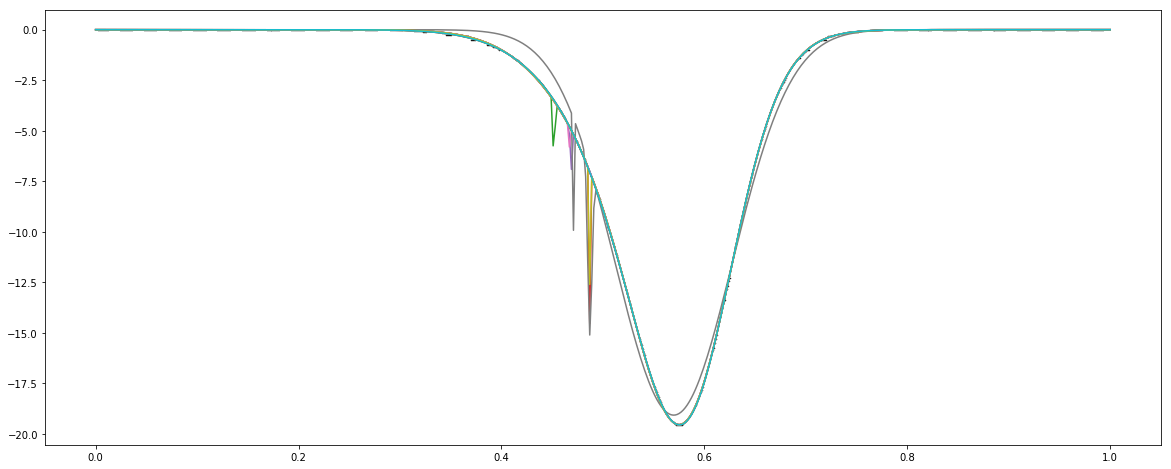

In [0]:
plt.figure(figsize=(20, 8))
plt.plot(x_data, y_data, '.k', markersize=1)
plt.plot(np_x, np_potentials.transpose())
plt.show()

In [0]:
index_min = np.argmin(loss_list[-1])
a_min = np_a_list[-1][index_min]
b_min = np_b_list[-1][index_min]
c_min = np_c_list[-1][index_min]
print(a_min)
print(b_min)
print(c_min)

[ 6.52788887 10.42182441  3.83903541]
[0.58619705 0.57217621 0.52033373]
[0.04039297 0.05612389 0.07138125]
